In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import CartesianRepresentation, UnitSphericalRepresentation
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product

In [609]:
from rms import Star, Planet, STSP

In [2]:
from scipy.integrate import quad 

def limb_darkening(u_ld, r):
    u1, u2 = u_ld
    mu = np.sqrt(1 - r**2)
    return (1 - u1 * (1 - mu) - u2 * (1 - mu)**2) / (1 - u1/3 - u2/6) / np.pi

def limb_darkening_normed(u_ld, r): 
    return limb_darkening(u_ld, r)/limb_darkening(u_ld, 0)

def total_flux(u_ld): 
    return 2 * np.pi * quad(lambda r: r * limb_darkening_normed(u_ld, r), 0, 1)[0]

spot_contrast = 0.7
u_ld = [0.5079, 0.2239]
f0 = total_flux(u_ld)

In [78]:
n_rotations = 10000
angles = np.arange(0, 2*np.pi, 2*np.pi/n_rotations) * u.rad

In [587]:
n_incs = 1
n_spots = 2

inc_stellar = np.array([90]) * u.deg
spot_radii = np.array([[0.2], [0.2]])
spot_lats = np.array([[0], [0]]) * u.deg 
spot_lons = np.array([[150], [210]]) * u.deg

$$ \lambda ^ { e } ( p , z ) = \left\{ \begin{array} { l l } { 0 , } & { 1 + p < z } \\ { \frac { 1 } { \pi } \left[ p ^ { 2 } \kappa _ { 0 } + \kappa _ { 1 } - \sqrt { \frac { 4 z ^ { 2 } - \left( 1 + z ^ { 2 } - p ^ { 2 } \right) ^ { 2 } } { 4 } } \right] , } & { | 1 - p | < z \leq 1 + p } \\ { p ^ { 2 } , } & { z \leq 1 - p } \\ { 1 , } & { z \leq p - 1 } \end{array} \right. $$

where

$$ \kappa _ { 1 } = \cos ^ { - 1 } \left[ \left( 1 - p ^ { 2 } + z ^ { 2 } \right) / 2 z \right] , \kappa _ { 0 } = \cos ^ { - 1 } \left[ \left( p ^ { 2 } + z ^ { 2 } - 1 \right) / 2 p z \right] $$

In [603]:
p = 0.1
spot_contrast = 0.
a_rs = 10
d = np.linspace(-15, 15, n_rotations)
z = np.abs(d)

In [604]:
tilted_spot_positions.y.value.shape

(10000, 2, 1)

In [605]:
tilted_spot_positions.z.shape

(10000, 2, 1)

In [606]:
usr = UnitSphericalRepresentation(spot_lons, spot_lats) 
cartesian = usr.represent_as(CartesianRepresentation)
rotate = rotation_matrix(angles[:, np.newaxis, np.newaxis], axis='z')
tilt = rotation_matrix(inc_stellar - 90*u.deg, axis='y')
rotated_spot_positions = cartesian.transform(rotate)
tilted_spot_positions = rotated_spot_positions.transform(tilt)

r = np.ma.masked_array(np.hypot(tilted_spot_positions.y.value, 
                                tilted_spot_positions.z.value), 
                       mask=tilted_spot_positions.x.value < 0)
ld = limb_darkening_normed(u_ld, r)

def occult(z, p): 
    lambda_e = np.zeros_like(z)
    ingress_egress = (np.abs(1-p) < z) & (z <= 1 + p)
    bottom = (z <= 1 - p)
    full = (z <= p - 1)
    kappa_0 = np.arccos((p**2 + z[ingress_egress]**2 - 1) / 
                        (2*p*z[ingress_egress]))
    kappa_1 = np.arccos((1 - p**2 + z[ingress_egress]**2) / 
                        (2*z[ingress_egress]))
    lambda_e[ingress_egress] = (p**2 * kappa_0 + kappa_1 - 
                                np.sqrt((4*z[ingress_egress]**2 - 
                                        (1+z[ingress_egress]**2-p**2)**2)/4))/np.pi
    lambda_e[bottom] = p**2
    lambda_e[full] = 1
#     plt.plot(lambda_e)
#     plt.show()
    return lambda_e

lambda_e = occult(z, p)

spots = []
for i in range(n_spots):
    forshortened_spot_radius = spot_radii[i, :]*np.sqrt(1 - r[:, i, 0]**2)
    r_spot = np.ma.masked_array(np.hypot(tilted_spot_positions.y.value[:, i, 0] - d, 
                                         tilted_spot_positions.z.value[:, i, 0]), 
                                mask=tilted_spot_positions.x.value[:, i, 0] < 0) / forshortened_spot_radius
    print(np.min([p/spot_radii[i, :], 1]))
    lambda_e_spot = (1 - spot_contrast) * p**2 * occult(r_spot, 
                                                        p=np.min([p/spot_radii[i, :], 1]))
    print(lambda_e_spot.min(), lambda_e_spot.max())
    spots.append(lambda_e_spot.filled(0))

lambda_e -= np.max(spots, axis=0)

f_spots = np.pi * spot_radii**2 * (1 - spot_contrast) * ld * np.sqrt(1 - r**2)

delta_f = (1 - np.sum(f_spots.filled(0)/f0, axis=1)[:, 0] - lambda_e)

[ 0.5]
0.0 0.0025
[ 0.5]
0.0 0.0025


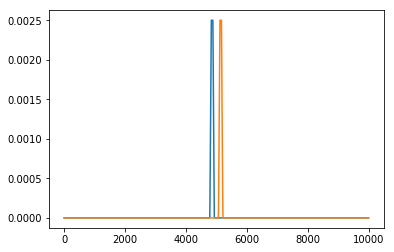

In [607]:
plt.plot(spots[0]);
plt.plot(spots[1]);

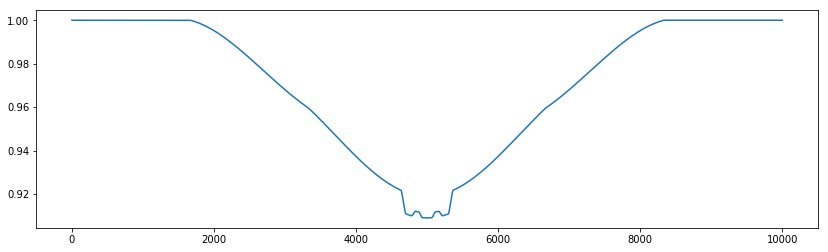

In [608]:
plt.figure(figsize=(14, 4))
plt.plot(delta_f);
# plt.axhline(1 - p**2, ls='--')
# plt.xlim([4500, 5500])